In [2]:
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
from operator import truediv


INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
import pyranges as pr
chr_list=['chr' + str(x) for x in range(1,20)]
genome_info_file='/grid/gillis/data//lohia/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
species='mouse'
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.sparse as ss


In [4]:
    # as PyRanges-object
    gr = pr.read_gtf(genome_info_file)
    df = gr.df
    gene_data = df[df['Feature'] == 'gene']
    gene_data['gene_id'] = [x.split('.')[0] for x in gene_data['gene_id']]
    gene_data['gene_id'].drop_duplicates(inplace=True)
    

    


    if species != 'human':
        gene_data['Chromosome'] = ['chr'+x for x in gene_data['Chromosome']]
        
    new = gene_data["Chromosome"].isin(chr_list)
  

    gene_data = gene_data[new]
    gene_data.sort_values(by=['Chromosome', 'Start'], inplace=True)
            
    gene_data = gene_data[gene_data['Chromosome'].isin(chr_list)] 

    gene_data_grouped_chromosome = gene_data.groupby('Chromosome')

<ipython-input-4-b7d38492c0b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_data['gene_id'] = [x.split('.')[0] for x in gene_data['gene_id']]
<ipython-input-4-b7d38492c0b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_data['gene_id'].drop_duplicates(inplace=True)
<ipython-input-4-b7d38492c0b3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [5]:
    proj_list_file = pd.read_csv('/grid/gillis/data/nfox/hi_c_data_processing/data_mouse/stats/project_network_counts.txt', sep=' ', names=['proj', 'count'])
    d2_list_intra = []
    counter = 0
    for proj in proj_list_file['proj'].tolist():
        
            d2_list_intra_agg_tmp = []

            counter = counter + 1
            print (counter)

        

            for chrom in chr_list:
                
                max_gene_array=[]  
                gene_index_row = []
                gene_id = []
                chrom_l = []
                
                file_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{proj}/500kbp_raw/{chrom}_intra_none.h5'
        
                hic = hm.hiCMatrix(file_name)

                entire_matrix = hic.matrix
                entire_matrix = entire_matrix.astype('float32')
                entire_matrix.setdiag(0, k=0)

                gene_chrom = gene_data_grouped_chromosome.get_group(chrom)

                for tss_start_x, tss_end_x, gene_x, strand in zip(gene_chrom['Start'], gene_chrom['End'], gene_chrom['gene_id'], gene_chrom['Strand']):

                        (bin_start, bin_end) = hic.getRegionBinRange(chrom, min(tss_start_x, tss_end_x), max(tss_start_x, tss_end_x) )

                        max_gene_array.append(entire_matrix[bin_start: bin_end+1].max(axis=0))
                        gene_id.append(gene_x)
                        chrom_l.append(chrom)
                        for i in range(bin_start, bin_end+1):
                            gene_index_row.append(i)

                chr_start, chr_end = hic.getChrBinRange(chrom)
                for given_bin in range(chr_start, (chr_end)):
                    if given_bin not in gene_index_row:
                        max_gene_array.append(entire_matrix[given_bin])
                        gene_index_row.append(given_bin)
                        chrom_l.append(chrom)
                        gene_id.append("non-gene")

                d2_list_intra_agg_tmp.extend(csr_matrix(ss.vstack(max_gene_array).T).sum(axis=0).getA().tolist()[0])
            
            
            d2_list_intra.append(d2_list_intra_agg_tmp)

1


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [24]:
    proj_list_file = pd.read_csv('/grid/gillis/data/nfox/hi_c_data_processing/data_mouse/stats/project_network_counts.txt', sep=' ', names=['proj', 'count'])
    d2_list_intra_agg = []
    counter = 0
    for proj in ['aggregates']:
        
            d2_list_intra_agg_tmp = []

            counter = counter + 1
            print (counter)
            full_gene_id = []

        

            for chrom in chr_list:
                
                max_gene_array=[]  
                gene_index_row = []
                gene_id = []
                chrom_l = []
                
                file_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{proj}/500kbp_raw/{chrom}_intra_none.h5'
        
                hic = hm.hiCMatrix(file_name)

                entire_matrix = hic.matrix
                entire_matrix = entire_matrix.astype('float32')
                entire_matrix.setdiag(0, k=0)

                gene_chrom = gene_data_grouped_chromosome.get_group(chrom)

                for tss_start_x, tss_end_x, gene_x, strand in zip(gene_chrom['Start'], gene_chrom['End'], gene_chrom['gene_id'], gene_chrom['Strand']):

                        (bin_start, bin_end) = hic.getRegionBinRange(chrom, min(tss_start_x, tss_end_x), max(tss_start_x, tss_end_x) )

                        max_gene_array.append(entire_matrix[bin_start: bin_end+1].max(axis=0))
                        gene_id.append(gene_x)
                        chrom_l.append(chrom)
                        for i in range(bin_start, bin_end+1):
                            gene_index_row.append(i)

                chr_start, chr_end = hic.getChrBinRange(chrom)
                for given_bin in range(chr_start, (chr_end)):
                    if given_bin not in gene_index_row:
                        max_gene_array.append(entire_matrix[given_bin])
                        gene_index_row.append(given_bin)
                        chrom_l.append(chrom)
                        gene_id.append("non-gene")

                d2_list_intra_agg_tmp.extend(csr_matrix(ss.vstack(max_gene_array).T).sum(axis=0).getA().tolist()[0])
                full_gene_id.extend(gene_id)
            
            
            d2_list_intra_agg.append(d2_list_intra_agg_tmp)
            

1


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
array_intra = np.array(d2_list_intra) 
a_intra = list(np.median(array_intra , axis=0))
res_intra = list(map(truediv, d2_list_intra_agg[0], a_intra))
res_intra_genes = [x for x,y in zip(res_intra, full_gene_id) if y != 'non-gene']

<ipython-input-8-02e8d10cbd93>:3: RuntimeWarning: invalid value encountered in double_scalars
  res_intra = list(map(truediv, d2_list_intra_agg[0], a_intra))


In [9]:
    import matplotlib.pyplot as plt
    %matplotlib inline
    import seaborn as sns

In [10]:
    proj_list_file = pd.read_csv('/grid/gillis/data/nfox/hi_c_data_processing/data_mouse/stats/project_network_counts.txt', sep=' ', names=['proj', 'count'])
    d2_list = []
    counter = 0
    for proj in proj_list_file['proj'].tolist():
            counter = counter + 1
            print (counter)
            file_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{proj}/500kbp_raw/inter_none.h5'
        
            hic = hm.hiCMatrix(file_name)

            entire_matrix = hic.matrix
            entire_matrix = entire_matrix.astype('float32')
            entire_matrix.setdiag(0, k=0)
            
            max_gene_array=[]  
            gene_index_row = []
            gene_id = []
            chrom_l = []


            for chrom in chr_list:

                gene_chrom = gene_data_grouped_chromosome.get_group(chrom)

                for tss_start_x, tss_end_x, gene_x, strand in zip(gene_chrom['Start'], gene_chrom['End'], gene_chrom['gene_id'], gene_chrom['Strand']):

                        (bin_start, bin_end) = hic.getRegionBinRange(chrom, min(tss_start_x, tss_end_x), max(tss_start_x, tss_end_x) )

                        max_gene_array.append(entire_matrix[bin_start: bin_end+1].max(axis=0))
                        gene_id.append(gene_x)
                        chrom_l.append(chrom)
                        for i in range(bin_start, bin_end+1):
                            gene_index_row.append(i)

                chr_start, chr_end = hic.getChrBinRange(chrom)
                for given_bin in range(chr_start, (chr_end)):
                    if given_bin not in gene_index_row:
                        max_gene_array.append(entire_matrix[given_bin])
                        gene_index_row.append(given_bin)
                        chrom_l.append(chrom)
                        gene_id.append("non-gene")

            all_bins_by_gene = csr_matrix(ss.vstack(max_gene_array).T)
            
            
            d2_list.append(all_bins_by_gene.sum(axis=0).getA().tolist()[0])
            

1


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [25]:
    proj_list_file = pd.read_csv('/grid/gillis/data/nfox/hi_c_data_processing/data_mouse/stats/project_network_counts.txt', sep=' ', names=['proj', 'count'])
    d2_list_agg = []
    counter = 0
    for proj in ['aggregates']:
            counter = counter + 1
            print (counter)
            file_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{proj}/500kbp_raw/inter_none.h5'
        
            hic = hm.hiCMatrix(file_name)

            entire_matrix = hic.matrix
            entire_matrix = entire_matrix.astype('float32')
            entire_matrix.setdiag(0, k=0)
            
            max_gene_array=[]  
            gene_index_row = []
            gene_id = []
            chrom_l = []


            for chrom in chr_list:

                gene_chrom = gene_data_grouped_chromosome.get_group(chrom)

                for tss_start_x, tss_end_x, gene_x, strand in zip(gene_chrom['Start'], gene_chrom['End'], gene_chrom['gene_id'], gene_chrom['Strand']):

                        (bin_start, bin_end) = hic.getRegionBinRange(chrom, min(tss_start_x, tss_end_x), max(tss_start_x, tss_end_x) )

                        max_gene_array.append(entire_matrix[bin_start: bin_end+1].max(axis=0))
                        gene_id.append(gene_x)
                        chrom_l.append(chrom)
                        for i in range(bin_start, bin_end+1):
                            gene_index_row.append(i)

                chr_start, chr_end = hic.getChrBinRange(chrom)
                for given_bin in range(chr_start, (chr_end)):
                    if given_bin not in gene_index_row:
                        print (i)
                        max_gene_array.append(entire_matrix[given_bin])
                        gene_index_row.append(given_bin)
                        chrom_l.append(chrom)
                        gene_id.append("non-gene")

            all_bins_by_gene = csr_matrix(ss.vstack(max_gene_array).T)
            
            
            d2_list_agg.append(all_bins_by_gene.sum(axis=0).getA().tolist()[0])
            

1
390
390
390
390
390
390
390
390
390
390
390
755
755
755
755
755
755
755
755
755
755
755
755
1075
1075
1075
1075
1075
1075
1075
1075
1075
1075
1075
1389
1389
1389
1389
1389
1389
1389
1389
1389
1389
1694
1694
1694
1694
1694
1694
1694
1694
1694
1694
1994
1994
1994
1994
1994
1994
1994
1994
1994
2285
2285
2285
2285
2285
2285
2285
2544
2544
2544
2544
2544
2544
2544
2544
2544
2793
2793
2793
2793
2793
2793
2793
3056
3056
3056
3056
3056
3056
3056
3300
3300
3300
3300
3300
3300
3300
3300
3300
3300
3300
3300
3300
3300
3542
3542
3542
3542
3542
3542
3783
3783
3783
3783
3783
3783
4033
4033
4033
4033
4033
4033
4033
4033
4241
4241
4241
4241
4241
4241
4241
4241
4439
4439
4439
4439
4439
4439
4439
4629
4629
4629
4629
4629
4629
4629
4629
4629
4629
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4811
4934
4934
4934
4934
4934
4934
4934
4934
4934
4934
4934


In [12]:
exp_file_path =  "/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/mouse_prioAggNet.h5"

In [13]:
exp_s = hm.hiCMatrix(exp_file_path)

In [14]:
exp_gene_list = [x[3].decode() for x in exp_s.cut_intervals]

In [26]:
array_inter = np.array(d2_list) 
np.fill_diagonal(array_inter, 0)
a_inter = list(np.median(array_inter , axis=0))
res_inter = list(map(truediv, a_inter, d2_list_agg[0]))
res_inter_genes_median = [x for x,y in zip(res_inter, full_gene_id) if y in exp_gene_list]

<ipython-input-26-5118d4b084a0>:4: RuntimeWarning: invalid value encountered in double_scalars
  res_inter = list(map(truediv, a_inter, d2_list_agg[0]))


In [27]:
array_intra = np.array(d2_list_intra) 
np.fill_diagonal(array_intra, 0)
a_intra = list(np.median(array_intra , axis=0))
res_intra = list(map(truediv,  a_intra,d2_list_intra_agg[0]))
res_intra_genes_median = [x for x,y in zip(res_intra, full_gene_id) if y in exp_gene_list]

<ipython-input-27-acbdbb3f5d38>:4: RuntimeWarning: invalid value encountered in double_scalars
  res_intra = list(map(truediv,  a_intra,d2_list_intra_agg[0]))


In [28]:
array_inter = np.array(d2_list) 
np.fill_diagonal(array_inter, 0)
a_inter = list(np.max(array_inter , axis=0))
res_inter = list(map(truediv, a_inter, d2_list_agg[0]))
res_inter_genes_max = [x for x,y in zip(res_inter, full_gene_id) if y in exp_gene_list]



array_intra = np.array(d2_list_intra) 
np.fill_diagonal(array_intra, 0)
a_intra = list(np.max(array_intra , axis=0))
res_intra = list(map(truediv, a_intra,d2_list_intra_agg[0]))
res_intra_genes_max = [x for x,y in zip(res_intra, full_gene_id) if y in exp_gene_list]

<ipython-input-28-44cb632d9bf8>:4: RuntimeWarning: invalid value encountered in double_scalars
  res_inter = list(map(truediv, a_inter, d2_list_agg[0]))
<ipython-input-28-44cb632d9bf8>:12: RuntimeWarning: invalid value encountered in double_scalars
  res_intra = list(map(truediv, a_intra,d2_list_intra_agg[0]))


In [29]:
df_intra_median = pd.DataFrame(res_intra_genes_median, columns = ['count'])
df_intra_median['type'] = 'cis_median'
df_intra_max = pd.DataFrame(res_intra_genes_max, columns = ['count'])
df_intra_max['type'] = 'cis_max'

df_inter_median = pd.DataFrame(res_inter_genes_median, columns = ['count'])
df_inter_median['type'] = 'trans_median'
df_inter_max = pd.DataFrame(res_inter_genes_max, columns = ['count'])
df_inter_max['type'] = 'trans_max'

In [30]:
df_fold = pd.concat([df_intra_median, df_inter_median,df_intra_max, df_inter_max])

In [31]:
df_fold_max = pd.concat([df_intra_max, df_inter_max])
df_fold_max['fold'] = 1/df_fold_max['count'] 
df_fold_median = pd.concat([df_intra_median, df_inter_median])
df_fold_median['fold'] = 1/df_fold_median['count'] 

In [32]:
df_fold['fold'] = 1/df_fold['count'] 

In [33]:
df_fold.to_csv('mouse_fold.csv', index=False)

In [36]:
df_fold.shape[0]/4

20672.0

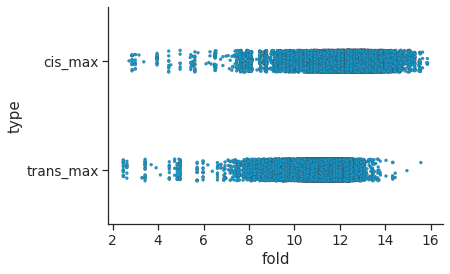

In [429]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)
import joypy

ax = sns.stripplot(data=df_fold_max, x ='fold', y='type',palette=['#129BD1', '#129BD1'], dodge=True, s=3, linewidth=0.2)
#ax.set(xscale="log")
for i, patch in enumerate(ax.artists):
        # Boxes from left to right
            patch.set_hatch('//')
            

[None]

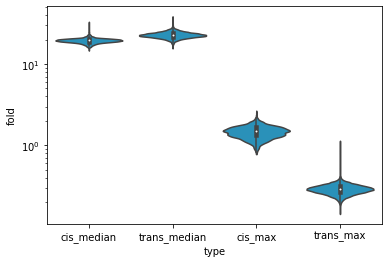

In [22]:
ax = sns.violinplot(data=df_fold, y ='fold', x='type',palette=['#129BD1', '#129BD1'], dodge=True, cut=0, scale="width")
ax.set(yscale="log")
#for i, patch in enumerate(ax.artists):
        # Boxes from left to right
#            patch.set_hatch('//')

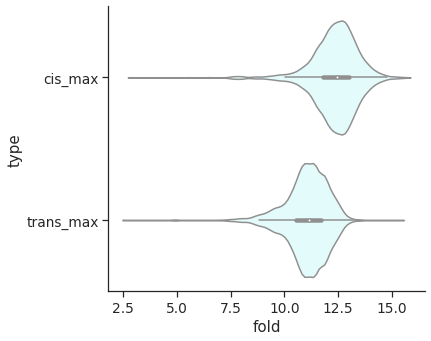

In [424]:
ax = sns.catplot(kind='violin', data=df_fold_max, x ='fold', y='type',palette=['lightcyan', 'lightcyan'], dodge=True, cut=0, scale="width", aspect=2.5/2)
#ax.set(xscale="log")


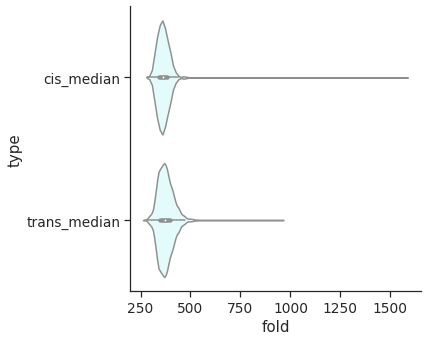

In [427]:
ax = sns.catplot(kind='violin', data=df_fold_median, x ='fold', y='type',palette=['lightcyan', 'lightcyan'], dodge=True, cut=0, scale="width", aspect=2.5/2)
#ax.set(xscale="log")


In [432]:
df_fold_median.shape[0]/2

23465.0

In [420]:
df_fold

count        type        fold
0      0.002016  cis_median  496.144828
1      0.002016  cis_median  496.144828
2      0.002016  cis_median  496.144828
3      0.002016  cis_median  496.144828
4      0.002016  cis_median  496.144828
...         ...         ...         ...
23460  0.087642   trans_max   11.410037
23461  0.087642   trans_max   11.410037
23462  0.087642   trans_max   11.410037
23463  0.087642   trans_max   11.410037
23464  0.087642   trans_max   11.410037

[93860 rows x 3 columns]

In [146]:
df_fold

count          type      fold
0      0.002039    cis_median  0.203871
1      0.002039    cis_median  0.203871
2      0.002039    cis_median  0.203871
3      0.002039    cis_median  0.203871
4      0.002039    cis_median  0.203871
...         ...           ...       ...
55406  0.002804  trans_median  0.280373
55407  0.002804  trans_median  0.280373
55408  0.002804  trans_median  0.280373
55409  0.002804  trans_median  0.280373
55410  0.002804  trans_median  0.280373

[110822 rows x 3 columns]

ValueError: cannot reindex from a duplicate axis

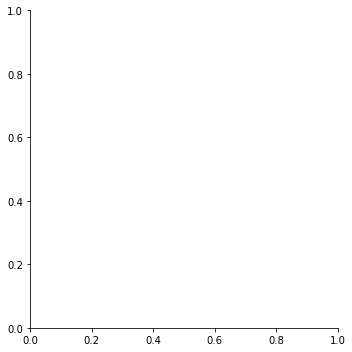

In [151]:
sns.displot( data=df_fold, x='count', kind="kde")

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

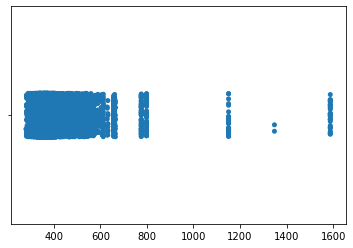

In [92]:
sns.stripplot(res_intra_genes)

In [86]:
min(res_intra_genes)

280.34703496379785

In [81]:
df_fold

f   type
0      10.227609    cis
1      10.227609    cis
2      10.227609    cis
3      10.227609    cis
4      10.227609    cis
...          ...    ...
55406  11.410037  trans
55407  11.410037  trans
55408  11.410037  trans
55409  11.410037  trans
55410  11.410037  trans

[110822 rows x 2 columns]

In [67]:
g = sns.stripplot( data=df_fold, col='type')


ValueError: The following variable cannot be assigned with wide-form data: `col`